In [1]:
from jax import config
config.update('jax_enable_x64', True)
from pathlib import Path

import jax
import gpjax as gpx
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from uncprop.models.vsem.experiment import summarize_rep, load_results
from uncprop.utils.plot import set_plot_theme, smart_subplots
from uncprop.utils.grid import plot_coverage_curve_reps

colors = set_plot_theme()
base_dir = Path('/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper')
output_dir = base_dir / 'out' / 'final'

/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# read experiment output

out_dir = base_dir / 'out' / 'vsem'
gp_subdirs = ['gp_N4', 'gp_N8', 'gp_N16']
clip_gp_subdirs = ['clip_gp_N4', 'clip_gp_N8', 'clip_gp_N16']

gp_results = load_results(out_dir, gp_subdirs)
clip_gp_results = load_results(out_dir, clip_gp_subdirs)

results = {'gp': gp_results, 'clip_gp': clip_gp_results}

### Coverage Plots

In [ ]:
ndesign = [4, 8, 16]
approx = ['mean', 'eup', 'ep']
surrogate_labels = ['gp', 'clip_gp']
plots = {}

for lbl in surrogate_labels:
    surrogate_results = results[lbl]
    plots[lbl] = smart_subplots(nrows=3, ncols=3, flatten=False)
    fig, axs = plots[lbl]

    for n_idx, n in enumerate(ndesign):
        subdir_name = f'{lbl}_N{n}'
        res = results[lbl][subdir_name]['results']
        for dist_idx, dist_name in enumerate(approx):
            ax = axs[n_idx, dist_idx]
            idx = list(res['dist_names']).index(dist_name)

            plot_coverage_curve_reps(log_coverage=res['log_coverage'][:,[idx],:], 
                                    probs=res['probs'], 
                                    names=[dist_name],
                                    colors=colors,
                                    qmin=0.05,
                                    qmax=0.95,
                                    single_plot=True,
                                    ax=ax,
                                    alpha=0.2, max_cols=3)
            
            if n_idx == 0: # first row
                ax.set_title(dist_name, fontsize=ax.title.get_fontsize() * 2)
            if n_idx != (len(ndesign)-1): # all but final row
                ax.set_xlabel(None)
                # ax.set_xticklabels([])
            else:
                ax.set_xlabel('nominal', fontsize=ax.xaxis.label.get_size() * 2)
            if dist_idx != 0: # all but first column
                ax.set_ylabel(None)
                # ax.set_yticklabels([])
            else:
                ax.set_ylabel(f'actual (N = {n})', fontsize=ax.yaxis.label.get_size() * 2)

            ax.get_legend().remove()


plots['gp'][0].savefig(output_dir / 'vsem_coverage_gp.png',
                       bbox_inches='tight')
plots['clip_gp'][0].savefig(output_dir / 'vsem_coverage_clip_gp.png',
                            bbox_inches='tight')

display(plots['gp'][0])
display(plots['clip_gp'][0])


In [ ]:
from uncprop.utils.grid import plot_coverage_curve_reps

for subdir, info in gp_results.items():
    res = info['results']
    
    # top row
    set_title = (subdir == 'clip_gp_')

    if subdir == 'clip_gp_N4':
        set_title = True

    plot_coverage = plot_coverage_curve_reps(log_coverage=res['log_coverage'], 
                                             probs=res['probs'], 
                                             names=res['dist_names'],
                                             colors=colors,
                                             qmin=0.05,
                                             qmax=0.95,
                                             single_plot=False,
                                             alpha=0.3, max_cols=3)

## Investigate specific reps

In [ ]:
subdir_name = 'clip_gp_N4'
rep_idx = 4

grid, results, log_dens, plots = summarize_rep(out_dir=out_dir,
                                               subdir_name=subdir_name,
                                               rep_idx=rep_idx,
                                               n_reps=100)

# TEMP

In [2]:
from uncprop.core.surrogate import Surrogate, SurrogateDistribution
from uncprop.core.samplers import init_cut_kernel, mcmc_loop
from uncprop.core.distribution import Distribution, GaussianFromNumpyro
from numpyro.distributions import MultivariateNormal

key = jr.key(2342343)

In [ ]:
class TestDist(Distribution):

    def __init__(self, input):
        self.input = input

    @property
    def dim(self) -> int:
        return 1

    @property
    def support(self) -> tuple[tuple, tuple] | None:
        """
        Should return tuple of the form lower, upper where lower and upper
        are each tuples of length `dim` giving the dimension-by-dimension
        lower and upper bounds, respectively. Should be `-jnp.inf` or 
        `jnp.inf` for unbounded dimensions. None is interpreted as unconstrained.
        """
        return None
    
    def sample(self, key, n: int = 1):
        return jnp.array(-0.5 * self.input ** 2)


class TestSurrogate(Surrogate):
    def __call__(self, input):
        return TestDist(input)
    
    @property
    def input_dim(self) -> int:
        return 1


class TestSurrogateDist(SurrogateDistribution):

    def __init__(self, surrogate):
        self._surrogate = surrogate

    @property
    def surrogate(self) -> Surrogate:
        return self._surrogate

    @property
    def dim(self) -> int:
        return 1

    @property
    def support(self) -> tuple[tuple, tuple] | None:
        return None
    
    def log_density(self, input):
        return self.surrogate(input)

In [ ]:
surrogate = TestSurrogate()
dist = TestSurrogateDist(surrogate)

key_init, key_sample = jr.split(key, 2)

initial_state, kernel = init_cut_kernel(key=key_init,
                                        surrogate_dist=dist,
                                        initial_position=jnp.array([0.0]),
                                        u_prop_cov=jnp.array([[1.0]]))

In [ ]:
out = mcmc_loop(key=key_sample,
                kernel=kernel,
                initial_state=initial_state,
                num_samples=100_000)

### Test with VSEM

In [4]:
from uncprop.models.vsem.experiment import VSEMReplicate
from uncprop.core.samplers import get_trace_plots

key = jr.key(23434)
key, key_rep = jr.split(key)

rep = VSEMReplicate(key=key,
                    n_design=8,
                    noise_sd=1.0,
                    jitter=1e-6)

rep(surrogate_tag='clip_gp')

Initial loss 42.94622655485319
Final loss 40.02839158787697
gp scale: 115.08257643352928
gp lengthscales: [0.53971428 5.65222313]
gp noise std dev: 0.00015081087689848698


In [ ]:
low, high = rep.posterior.support

def lp_sampler(key, u_curr, u_prop):
    u = jnp.stack([u_curr, u_prop], axis=0)
    lp = rep.surrogate_posterior_clip_gp.log_density(u).sample(key).squeeze()
    return jnp.where(jnp.all((u >= low) & (u <= high), axis=1), lp, -jnp.inf)

def lp_sample_ind(key, u_curr, u_prop):
    lp_curr = rep.surrogate_posterior_clip_gp.log_density(u_curr).sample(key).squeeze()
    lp_prop = rep.surrogate_posterior_clip_gp.log_density(u_prop).sample(key).squeeze()

    lp = jnp.array([lp_curr, lp_prop])
    u = jnp.stack([u_curr, u_prop], axis=0)
    return jnp.where(jnp.all((u >= low) & (u <= high), axis=1), lp, -jnp.inf)
    

In [ ]:
key, key_init_pos, key_init_ker, key_sample = jr.split(key, 4)

initial_position = rep.posterior.prior.sample(key_init_pos).squeeze()
prop_cov = jnp.diag(jnp.array([0.6 ** 2, 4.0 ** 2]))

initial_state, kernel = init_cut_kernel(key=key_init_ker,
                                        logp_sampler=lp_sampler,
                                        initial_position=initial_position,
                                        u_prop_cov=prop_cov)

In [ ]:
out = mcmc_loop(key=key_sample,
                kernel=kernel,
                initial_state=initial_state,
                num_samples=100_000)

samp = out.position[50_000:]
samp_dict = {'av': samp[:,0], 'veg_init': samp[:,1]}

In [ ]:
plt.plot(out.logdensity)
get_trace_plots(trace=samp_dict, num_rows=1)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


def plot_2d_kde(samp, low, high, contours=True, gridsize=200):
    """
    Plot a 2D kernel density estimate as a heatmap, with optional contours.

    Parameters
    ----------
    samp : array_like, shape (n, 2)
        Samples from a 2D distribution.
    low : array_like, shape (2,)
        Lower bounds of the support (x_min, y_min).
    high : array_like, shape (2,)
        Upper bounds of the support (x_max, y_max).
    contours : bool, default=True
        Whether to overlay contour lines on the heatmap.
    gridsize : int, default=200
        Number of grid points per dimension used for the KDE evaluation.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The created figure.
    ax : matplotlib.axes.Axes
        The created axes.
    """
    samp = np.asarray(samp)
    low = np.asarray(low)
    high = np.asarray(high)

    if samp.ndim != 2 or samp.shape[1] != 2:
        raise ValueError("samp must have shape (n, 2)")
    if low.shape != (2,) or high.shape != (2,):
        raise ValueError("low and high must have shape (2,)")

    # Create evaluation grid
    x = np.linspace(low[0], high[0], gridsize)
    y = np.linspace(low[1], high[1], gridsize)
    xx, yy = np.meshgrid(x, y)
    grid = np.vstack([xx.ravel(), yy.ravel()])

    # Fit KDE and evaluate on grid
    kde = gaussian_kde(samp.T)
    zz = kde(grid).reshape(gridsize, gridsize)

    # Plot
    fig, ax = plt.subplots()

    im = ax.imshow(
        zz,
        origin="lower",
        extent=(low[0], high[0], low[1], high[1]),
        aspect="auto",
    )

    if contours:
        ax.contour(
            xx,
            yy,
            zz,
            levels=10,
            linewidths=1.0,
        )

    ax.set_xlim(low[0], high[0])
    ax.set_ylim(low[1], high[1])
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    fig.colorbar(im, ax=ax, label="Density")

    return fig, ax


In [ ]:
plot_2d_kde(samp, low=rep.posterior.support[0], high=rep.posterior.support[1], contours=True, gridsize=200)
rep.density_comparison.plot(normalized=True, log_scale=False, max_cols=4)

### Test rkpcn

In [6]:
from uncprop.utils.distribution import _sample_gaussian_tril
from uncprop.core.samplers import _pcn_proposal, _mh_accept_reject, init_rkpcn_kernel

key, key_init_pos, key_sample = jr.split(key, 3)
initial_position = rep.posterior.prior.sample(key_init_pos).squeeze()
prop_cov = jnp.diag(jnp.array([0.2 ** 2, 1.0 ** 2]))

In [8]:
from uncprop.utils.distribution import _sample_gaussian_tril
from uncprop.core.samplers import _pcn_proposal, _mh_accept_reject, init_rkpcn_kernel

key, key_jit, key_proposal, key_accept = jr.split(key, 4)

# pcn correlation parameter
rho = 0.99

# proposal cholesky factor
L = jnp.linalg.cholesky(prop_cov, upper=False)

# GP
gp = rep.surrogate_posterior_clip_gp.surrogate

# Current position
key, key_u = jr.split(key, 2)
u = rep.posterior.prior.sample(key).squeeze()
fu = gp(u).sample(key_jit).squeeze()

# proposal
v = _sample_gaussian_tril(key_proposal, m=u, L=L).squeeze()

In [ ]:
# just-in-time sample
fv = gp.condition_then_predict(v, given=(u, fu)).sample(key_jit).squeeze()

In [ ]:
# Projection of law(f) onto (u, v)
uv = jnp.stack([u, v], axis=0)
fuv = jnp.stack([fu, fv], axis=0)
fuv_dist = gp(uv)

In [ ]:
# f update
guv = _pcn_proposal(key_proposal, fuv, fuv_dist.mean, fuv_dist.chol, rho=rho).squeeze()
gu = guv[0]
gv = guv[1]

In [ ]:
log_density = lambda x: x

# u update
u_next, lp_next, log_alpha, accept = _mh_accept_reject(key_accept,
                                                       lp_curr=log_density(gu), 
                                                       lp_prop=log_density(gv),
                                                       u_curr=u, u_prop=v)
g_u_next = jax.lax.cond(accept, lambda _: gv, lambda _: gu, operand=None)

In [17]:
rho = 0.999

low, high = rep.posterior.support
upper_bound = lambda u: rep.posterior.prior.log_density(u) + rep.posterior.likelihood.log_density_upper_bound(u)

def log_density(f, u):
    upper = upper_bound(u)
    lp = jnp.clip(f, max=upper)
    lp = jnp.where(jnp.all((u >= low) & (u <= high)), lp, -jnp.inf)
    return lp.squeeze()

initial_state, kernel = init_rkpcn_kernel(key=key,
                                          log_density=log_density,
                                          gp=gp,
                                          initial_position=u,
                                          u_prop_cov=prop_cov,
                                          pcn_cor=rho)

In [18]:
out = mcmc_loop(key=key_sample,
                kernel=kernel,
                initial_state=initial_state,
                num_samples=500_000)

samp = out.position[100_000:]
samp_dict = {'av': samp[:,0], 'veg_init': samp[:,1]}

(<Figure size 640x480 with 2 Axes>,
 array([<Axes: xlabel='samples', ylabel='av'>,
        <Axes: xlabel='samples', ylabel='veg_init'>], dtype=object))

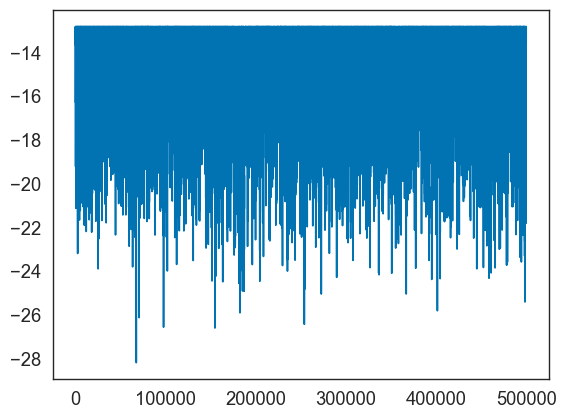

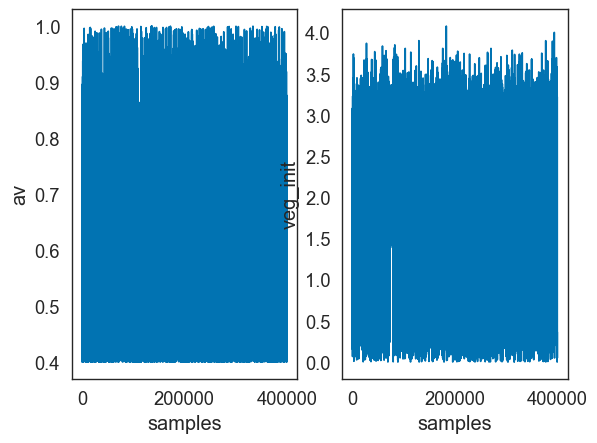

In [19]:
plt.plot(out.logdensity)
get_trace_plots(trace=samp_dict, num_rows=1)

(<Figure size 1600x300 with 8 Axes>,
 [<Axes: title={'center': 'exact'}, xlabel='av', ylabel='veg_init'>,
  <Axes: title={'center': 'mean'}, xlabel='av', ylabel='veg_init'>,
  <Axes: title={'center': 'eup'}, xlabel='av', ylabel='veg_init'>,
  <Axes: title={'center': 'ep'}, xlabel='av', ylabel='veg_init'>])

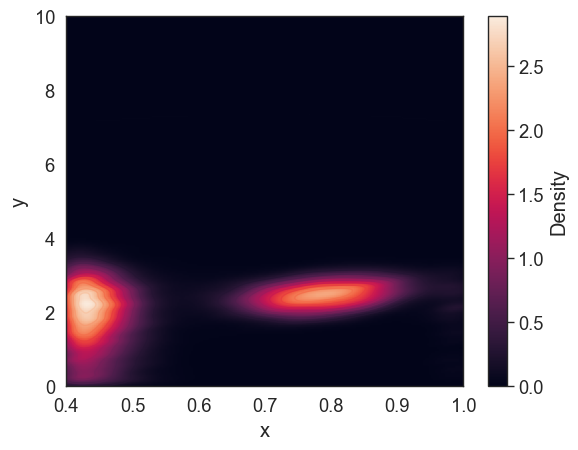

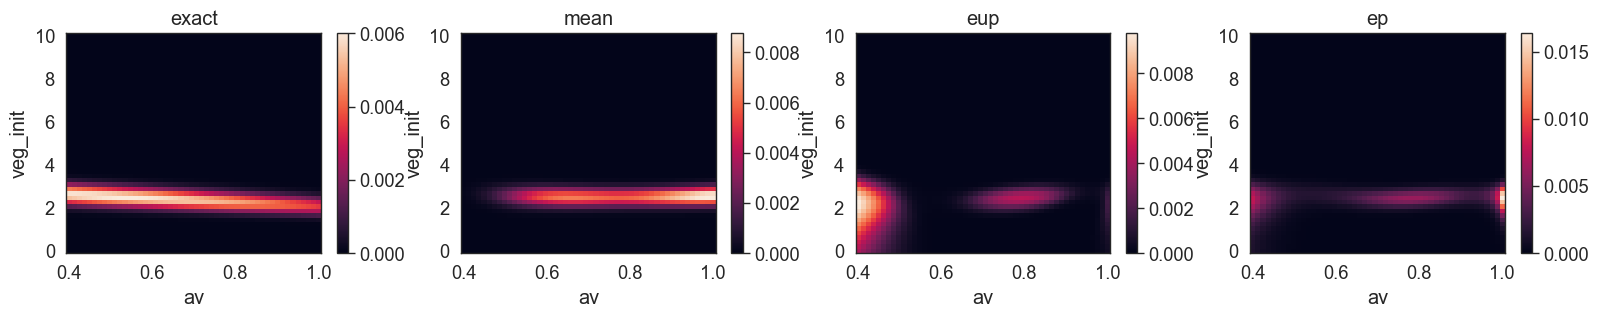

In [20]:
plot_2d_kde(samp, low=low, high=high, contours=True, gridsize=200)
rep.density_comparison.plot(normalized=True, log_scale=False, max_cols=4)